In [1]:
%matplotlib notebook

In [2]:
import soundfile as sf
import os
from python_speech_features import mfcc
from python_speech_features.sigproc import magspec
import matplotlib.pyplot as plt
import numpy as np
from numpy import sum, cumsum
import IPython.display as disp

In [3]:
def play_signal(s, fs):
    disp.display(disp.Audio(s, rate = fs))

In [4]:
def plot_signal(s):
    plt.figure(figsize = (9,2))
    plt.plot(s)
    plt.tight_layout()

def plot_features(feats):
    plt.figure(figsize = (9,2))
    plt.pcolormesh(feats.T)
    plt.colorbar()
    plt.tight_layout()
    
def plot_distances(dists, path = None):
    plt.figure()
    plt.pcolormesh(dists)
    if path is not None:
        plt.plot(path[:,1], path[:,0], color='r')
    plt.colorbar()

## Načti data

In [5]:
def read_audio(name):
    datadir = '../merlin/homes/kazi/izmolikova/dtw_data'
    #datadir = '../merlin/homes/kazi/izmolikova'
    s, fs = sf.read(os.path.join(datadir,f'{name}.wav'))
    return s, fs

In [6]:
s1, fs = read_audio('man_ae_9a')
s2, fs = read_audio('man_aw_9b')

In [7]:
play_signal(s1, fs)
play_signal(s2, fs)

<IPython.core.display.Javascript object>


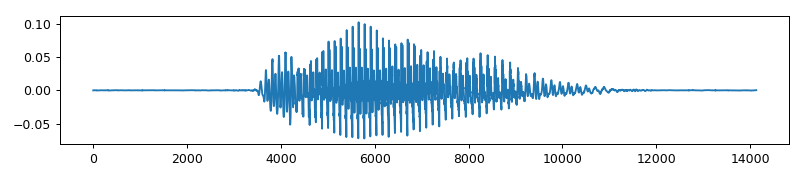

<IPython.core.display.Javascript object>


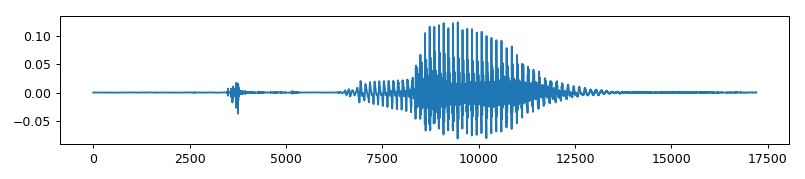

In [8]:
plot_signal(s1)
plot_signal(s2)

## Vypočítej příznaky

In [9]:
feats1 = mfcc(s1)
feats2 = mfcc(s2)

<IPython.core.display.Javascript object>


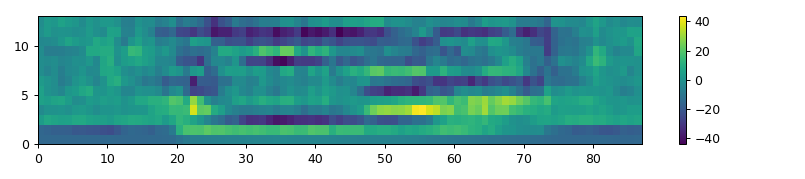

<IPython.core.display.Javascript object>


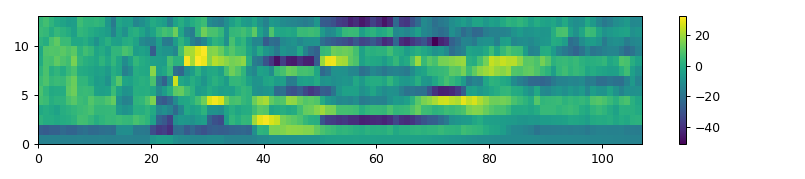

In [10]:
plot_features(feats1)
plot_features(feats2)

## Vypočítej vzdálenosti

In [11]:
def vector_distance(v1, v2):
    dist = sum((v1 - v2) ** 2)
    return dist

In [12]:
def vector_distance_all_to_all(feats1, feats2):
    dists = np.zeros((feats1.shape[0], feats2.shape[0]))

    for i1 in range(feats1.shape[0]):
        for i2 in range(feats2.shape[0]):
            dists[i1,i2] = vector_distance(feats1[i1,:], feats2[i2,:])
            
    return dists

In [13]:
dists = vector_distance_all_to_all(feats1, feats2)

<IPython.core.display.Javascript object>


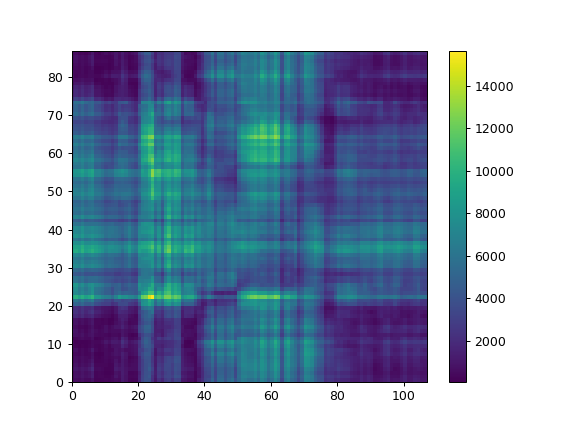

In [14]:
plot_distances(dists)

## Vypočítej kumulované vzdálenosti

In [15]:
def dists_to_cumdists(dists):
    # inicializuj matici kumulovanych vzdalenosti na nuly
    cumdists = np.zeros((dists.shape[0], dists.shape[1]))
    # inicializuj matici zpetnych ukazatelu na -1
    directions = -1 * np.ones(cumdists.shape)
    
    # inicializuj prvni radek a sloupec
    cumdists[:, 0] = cumsum(dists[:, 0])
    cumdists[0, :] = cumsum(dists[0, :])
    directions[1:, 0] = np.ones(directions[1:, 0].shape)
    directions[0, 1:] = 2*np.ones(directions[0, 1:].shape)
    
        
    for i1 in range(1, dists.shape[0]):
        for i2 in range(1, dists.shape[1]):
            d = dists[i1, i2]
            
            # spocitej 3 kandidaty na nejkratsi vzdalenost
            cand1 = cumdists[i1-1, i2-1] + d*2
            cand2 = cumdists[i1-1, i2] + d
            cand3 = cumdists[i1, i2-1] + d
            
            # vyber nejkratsi vzdalenost
            # uloz vzdalenost a zpetny ukazatel
            cumdists[i1, i2] = np.min([cand1, cand2, cand3])
            directions[i1, i2] = np.argmin([cand1, cand2, cand3])
    
    return cumdists, directions

In [16]:
cumdists, directions = dists_to_cumdists(dists)

## Vypočítej nejlepší cestu

In [17]:
def backtrack_path(directions):
    coor_cur = (directions.shape[0] - 1, directions.shape[1] - 1)
    path = [coor_cur]

    while coor_cur != (0,0):
        if directions[coor_cur] == 0:
            coor_next = (coor_cur[0] - 1, coor_cur[1] - 1)
        elif directions[coor_cur] == 1:
            coor_next = (coor_cur[0] - 1, coor_cur[1])
        elif directions[coor_cur] == 2:
            coor_next = (coor_cur[0], coor_cur[1] - 1)

        path.append(coor_next)
        coor_cur = coor_next

    path.reverse()
    path = np.array(path)
    
    return path

In [18]:
def best_path_cost(cumdists):
    return cumdists[-1,-1] / (cumdists.shape[0] + cumdists.shape[1])

In [19]:
path = backtrack_path(directions)
cost = best_path_cost(cumdists)

<IPython.core.display.Javascript object>


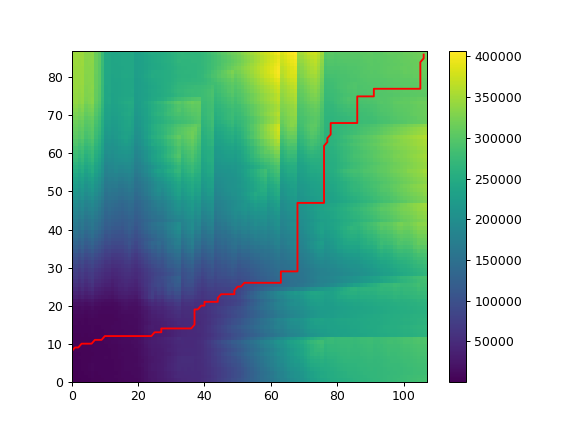

In [20]:
plot_distances(cumdists, path)

In [21]:
cost

1637.877711011142

## Zabal vsechno do jedne funkce

In [22]:
def dtw(file1, file2):
    # nacti audio
    s1, fs = read_audio(file1)
    s2, fs = read_audio(file2)
    
    # vypocitej featury
    feats1 = mfcc(s1)
    feats2 = mfcc(s2)
    
    # vypocitej vzdalenosti
    dists = vector_distance_all_to_all(feats1, feats2)
    
    # vypocitej kumulovane vzdalenosti
    cumdists, directions = dists_to_cumdists(dists)
    
    # vypocitej nejlevnejsi cestu
    path = backtrack_path(directions)
    
    # vypocitej cenu cesty
    cost = best_path_cost(cumdists)
    
    middle_products = [s1, s2, fs, feats1, feats2, dists, cumdists, directions, path]
    return cost, middle_products

In [23]:
d, mid = dtw('man_ae_9a', 'man_aw_9b')
d

1637.877711011142

In [24]:
s1, s2, fs, feats1, feats2, dists, cumdists, directions, path = mid

<IPython.core.display.Javascript object>


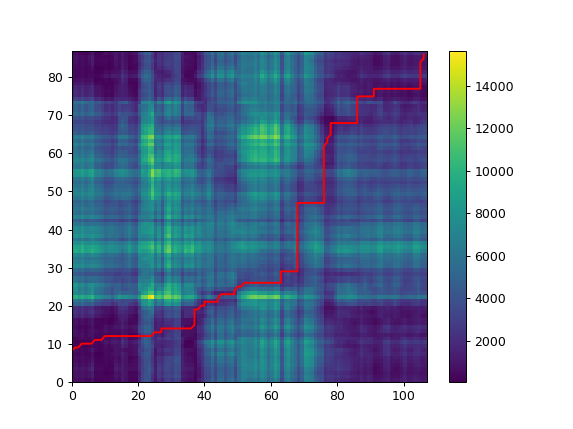

In [25]:
plot_distances(dists, path)

## Rozpoznej číslovku

In [26]:
refs = ['man_cb_za', 'woman_ac_1b', 'woman_ca_2a', 'man_cf_3b', 'man_al_4a',
       'woman_ac_5b', 'man_dl_6b', 'man_cr_7a', 'woman_bh_8a', 'woman_cg_9a']

test = 'woman_bi_8a'

rec_dists = []
for ref in refs:
    d = dtw(test, ref)[0]
    rec_dists.append(d)

In [27]:
rec_dists

[2243.274972072134,
 1527.2692976459819,
 1336.2029871682637,
 1579.741425896728,
 2068.645619773805,
 1549.6721254781153,
 1599.001975794854,
 1451.7942649201598,
 713.96107144787,
 1613.8646594404595]